In [1528]:
import numpy as np
import pandas as pd
from scipy.integrate import ode, solve_ivp
import altair as alt
alt.data_transformers.disable_max_rows()


DataTransformerRegistry.enable('default')

In [1529]:
def sir_ode(t,current,parms):
    beta, epsilon0, epsilon1, alpha, delta, gamma, c, n_icu, p_icu, CFR0, CFR1, N, epsilon0, epsilon1, intervention_time, intervention_factor = parms
    S,E,P,I0,I1,R0,R1 = current
    # ODEs
    I = I0 + I1
    if I > 0:
        CFR = CFR1 - min(1, n_icu / (N*I*p_icu))*(CFR1 - CFR0)
    else:
        CFR = CFR0
    if t > intervention_time and t < 300:
        beta = beta*intervention_factor
    dS = -beta*S*(epsilon0*P + I0 + epsilon1*I1)
    dE = beta*S*(epsilon0*P + I0 + epsilon1*I1) - alpha*E
    dP = alpha*E - delta*P
    dI0 = delta*P - (gamma + c*(1-gamma))*I0 # I0 = 0.1 delta = 0   dI0 <= 0 - (1)I0 = -0.1
    dI1 = c*(1-gamma)*I0 - gamma*I1
    dR0 = gamma*(1-CFR)*I0
    dR1 = gamma*(1-CFR)*I1
    return [dS,dE,dP,dI0,dI1,dR0,dR1]

In [1530]:
# Interesting parameters: intervention_factor = 0.4 -- 0.6
# epsilon1 = 0.05, c = 0.1 -- 0.15

N = 8000000
reproduction_num = 2.5
alpha = 0.25
epsilon0 = 0.15
epsilon1 = 0.15
delta = 1
gamma = 0.1
c = 0.15
CFR0 = 0.005
CFR1 = 0.01
p_icu = 0.0125
n_icu = 300 # beds
intervention_time = 70  #49
intervention_factor = 0.4


beta = reproduction_num/(epsilon0/delta + 1/gamma)

parms = [beta, epsilon0, epsilon1, alpha, delta, gamma, c, n_icu, p_icu, CFR0, CFR1, N, epsilon0, epsilon1, intervention_time, intervention_factor]
S = 1 - 20/N
E = 20/N
P = 0
I0 = 0
I1 = 0
R0 = 0
R1 = 0
init = [S,E,P,I0,I1,R0,R1]
times = np.linspace(0,500,500)

In [1531]:
sir_sol = solve_ivp(fun=lambda t, y: sir_ode(t, y, parms), method="RK45", t_span=[min(times),max(times)], y0=init, t_eval=times, rtol=1e-8)

In [1532]:
sir_out = pd.DataFrame({"t":sir_sol["t"],"S":sir_sol["y"][0],"E":sir_sol["y"][1],"P":sir_sol["y"][2],"I0":sir_sol["y"][3],"I1":sir_sol["y"][4],"R0":sir_sol["y"][5],"R1":sir_sol["y"][6]})

In [1533]:
sim = [ { 't': 0, 
          'S': S,
          'E': E,
          'P': P,
          'I0': I0,
          'I1': I1,
          'R0': R0,
          'R1': R1,
          'D' : 0}]
for t in range(1, 2000):
    current = sim[-1]
    deltas = sir_ode(t, [current['S'], 
                         current['E'], 
                         current['P'], 
                         current['I0'], 
                         current['I1'], 
                         current['R0'], 
                         current['R1']], parms)
    sim.append({ 't': t, 
                 'S': current['S'] + deltas[0],
                 'E': current['E'] + deltas[1],
                 'P': current['P'] + deltas[2],
                 'I0': current['I0'] + deltas[3],
                 'I1': current['I1'] + deltas[4],
                 'R0': current['R0'] + deltas[5],
                 'R1': current['R1'] + deltas[6],
                 'D' : 0})

In [1534]:
sir_out = pd.DataFrame(sim)

In [1535]:
sir_out["D"] = 1 - sir_out["S"] - sir_out["E"] - sir_out["P"] - sir_out["I0"] - sir_out["I1"] - sir_out["R0"] - sir_out["R1"]

In [1536]:

sir_out = sir_out * N
sir_out['t'] = sir_out['t']/N

In [1537]:
sir_out

,t,S,E,P,I0,I1,R0,R1,D
0,0.0,7.999980e+06,20.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.310224e-10
1,1.0,7.999980e+06,15.000000,5.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,1.310216e-10
2,2.0,7.999980e+06,11.434729,3.750000,5.000000,0.000000,0.000000e+00,0.000000e+00,1.070362e-10
3,3.0,7.999978e+06,9.946117,2.858682,7.575000,0.675000,4.975000e-01,0.000000e+00,2.500000e-03
4,4.0,7.999976e+06,9.455901,2.486529,8.653557,1.630125,1.251213e+00,6.716250e-02,6.625000e-03
...,...,...,...,...,...,...,...,...,...
1995,1995.0,4.626044e+06,0.000077,0.000020,0.000094,0.000168,1.423201e+06,1.921342e+06,2.941264e+04
1996,1996.0,4.626044e+06,0.000075,0.000019,0.000092,0.000164,1.423201e+06,1.921342e+06,2.941264e+04
1997,1997.0,4.626044e+06,0.000073,0.000019,0.000089,0.000160,1.423201e+06,1.921342e+06,2.941264e+04
1998,1998.0,4.626044e+06,0.000072,0.000018,0.000087,0.000156,1.423201e+06,1.921342e+06,2.941264e+04


#### Visualisation

In [1545]:
plot_values = sir_out[['t','D','E','I0','I1','P']].melt('t')
#plot_values = plot_values[(plot_values['variable'] != 'S') && ]

In [1546]:
#plot_values = plot_values[plot_values['t'] < 300]

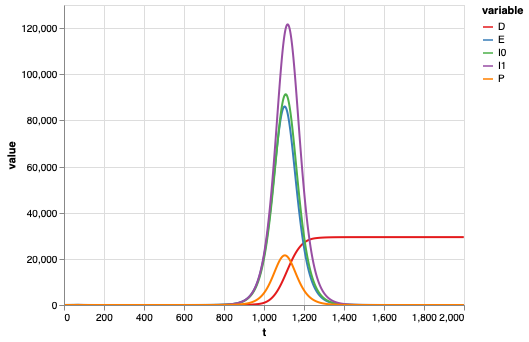

In [1547]:
alt.Chart(plot_values).mark_line().encode(
    x='t',
    y='value',
    color=alt.Color('variable', scale=alt.Scale(scheme="set1")),
    tooltip=['t','variable','value']
).properties(
).interactive()

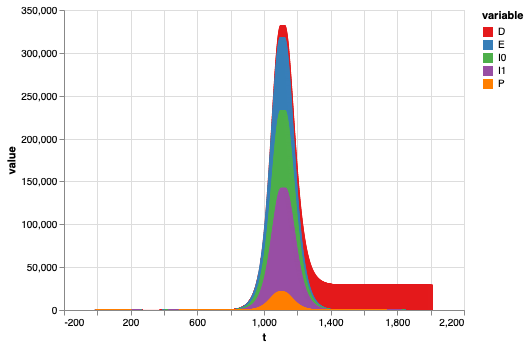

In [1548]:
alt.Chart(plot_values).mark_bar().encode(
    x='t',
    y=alt.Y('value', stack=True),
    color=alt.Color('variable', scale=alt.Scale(scheme="set1"))
).properties(
).interactive()